## Import Library & API

In [ ]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ardl import ARDL, ardl_select_order, UECM
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model
# import warnings
import fredapi as fa
from datetime import date
from twelvedata import TDClient
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import re
import os
os.chdir('/Users/fulinq/Documents/KMITL/FinancialEngineering/Y4/Y4T1/PROJECT/ARDL-ECM/Code/Gold')

In [25]:
fred = fa.Fred(api_key='c948956426006ca126a2dd3bd1f07cee')
td = TDClient(apikey='aa61c51218c248698467af34d09b9d46')

## Data Retrieve ##

In [87]:
# 1. Fetch First Batch (Latest 5000 records)
ts1 = td.time_series(
    symbol="XAU/USD",
    interval="1day",
    outputsize=5000,
    timezone="Asia/Bangkok"
)
df1 = ts1.as_pandas()

# Get the oldest date from batch 1 to serve as the end_date for batch 2
oldest_date = df1.index.min()
time.sleep(10) # Wait slightly to respect API rate limits

# 2. Fetch Second Batch (Previous 5000 records)
ts2 = td.time_series(
    symbol="XAU/USD",
    interval="1day",
    outputsize=5000,
    timezone="Asia/Bangkok",
    end_date=oldest_date
)
df2 = ts2.as_pandas()

# 3. Concatenate DataFrames
gold = pd.concat([df1, df2])
all_gold = gold.copy()
all_gold.to_csv('all_gold_data.csv')

# Select only close price
gold = gold[['close']].copy()

# Rename column to 'Gold'
gold.rename(columns={'close': 'Gold'}, inplace=True)

# Convert index to Datetime and remove Timezone (Crucial for merging with FRED)
gold.index = pd.to_datetime(gold.index).tz_localize(None)

# Sort index (Oldest -> Newest)
gold = gold.sort_index()

# Remove duplicate indices (in case of overlap between batches)
gold = gold[~gold.index.duplicated(keep='first')]

# Check and Fill NA
print(f'NaN value before: {gold.isna().sum().sum()}')
gold = gold.ffill()
print(f'NaN value after: {gold.isna().sum().sum()}')

gold

NaN value before: 0
NaN value after: 0


,Gold
datetime,
1988-01-04,480.76001
1988-01-05,480.76001
1988-01-06,483.28000
1988-01-07,481.31000
1988-01-08,483.95001
...,...
2026-01-29,5310.53137
2026-01-30,4940.66781
2026-01-31,4865.45982


In [88]:
dollar_index = fred.get_series('DTWEXBGS') #nominal dollar index
dollar_index.rename('Dollar Index', inplace=True)
dollar_index.index = pd.to_datetime(dollar_index.index) 

# month_ends = pd.date_range(start=dollar_index.index.min(), end=dollar_index.index.max(), freq='M')
# new_index = dollar_index.index.union(month_ends)
# dollar_index = dollar_index.reindex(new_index)

print(f'NaN value : {dollar_index.isna().sum()}')
dollar_index = dollar_index.ffill()
print(f'NaN value after ffill: {dollar_index.isna().sum()}')
dollar_index

NaN value : 207
NaN value after ffill: 0


2006-01-02    101.4155
2006-01-03    100.7558
2006-01-04    100.2288
2006-01-05    100.2992
2006-01-06    100.0241
                ...   
2026-01-19    120.4478
2026-01-20    119.8255
2026-01-21    119.7240
2026-01-22    119.5823
2026-01-23    119.2855
Name: Dollar Index, Length: 5235, dtype: float64

In [89]:
ppi = fred.get_series('PPIACO') #PPI all commodities
ppi.rename('PPI', inplace=True)
ppi.index = pd.to_datetime(ppi.index)
print(f'NaN value : {ppi.isna().sum()}')
ppi = ppi.ffill()
print(f'NaN value after ffill: {ppi.isna().sum()}')
ppi

NaN value : 0
NaN value after ffill: 0


1913-01-01     12.100
1913-02-01     12.000
1913-03-01     12.000
1913-04-01     12.000
1913-05-01     11.900
               ...   
2025-08-01    262.110
2025-09-01    262.094
2025-10-01    260.724
2025-11-01    261.358
2025-12-01    260.686
Name: PPI, Length: 1356, dtype: float64

In [90]:
fed_fund = fred.get_series('FEDFUNDS') #federal fund rate
fed_fund.rename('Federal Fund Rate', inplace=True)
fed_fund.index = pd.to_datetime(fed_fund.index)
fed_fund = fed_fund.mul(0.01)

# month_ends = pd.date_range(start=fed_fund.index.min(), end=fed_fund.index.max(), freq='M')
# new_index = fed_fund.index.union(month_ends)
# fed_fund = fed_fund.reindex(new_index)

print(f'NaN value before processing: {fed_fund.isna().sum()}')
fed_fund = fed_fund.ffill()
fed_fund.rename('Federal Fund Rate', inplace=True) # Re-apply the name after reindexing
print(f'NaN value after processing: {fed_fund.isna().sum()}')
fed_fund

NaN value before processing: 0
NaN value after processing: 0


1954-07-01    0.0080
1954-08-01    0.0122
1954-09-01    0.0107
1954-10-01    0.0085
1954-11-01    0.0083
               ...  
2025-08-01    0.0433
2025-09-01    0.0422
2025-10-01    0.0409
2025-11-01    0.0388
2025-12-01    0.0372
Name: Federal Fund Rate, Length: 858, dtype: float64

In [91]:
vix = fred.get_series('VIXCLS') #CBOE Volatility Index: VIX
vix.rename('VIX', inplace=True)
vix.index = pd.to_datetime(vix.index)
print(f'NaN value : {vix.isna().sum()}')
vix = vix.ffill()
print(f'NaN value after ffill: {vix.isna().sum()}')
vix

NaN value : 301
NaN value after ffill: 0


1990-01-02    17.24
1990-01-03    18.19
1990-01-04    19.22
1990-01-05    20.11
1990-01-08    20.26
              ...  
2026-01-23    16.09
2026-01-26    16.15
2026-01-27    16.35
2026-01-28    16.35
2026-01-29    16.88
Name: VIX, Length: 9413, dtype: float64

In [92]:
unemploy = fred.get_series('ICSA') #Initial Claims
unemploy.rename('ISCA', inplace=True)
unemploy.index = pd.to_datetime(unemploy.index)
print(f'NaN value : {unemploy.isna().sum()}')
unemploy = unemploy.ffill()
print(f'NaN value after ffill: {unemploy.isna().sum()})')
unemploy

NaN value : 0
NaN value after ffill: 0)


1967-01-07    208000.0
1967-01-14    207000.0
1967-01-21    217000.0
1967-01-28    204000.0
1967-02-04    216000.0
                ...   
2025-12-27    200000.0
2026-01-03    207000.0
2026-01-10    199000.0
2026-01-17    210000.0
2026-01-24    209000.0
Name: ISCA, Length: 3082, dtype: float64

In [93]:
ip = fred.get_series('INDPRO') #Industrial Production Index
ip.rename('Industrial Production', inplace=True)
ip.index = pd.to_datetime(ip.index)
print(f'NaN value : {ip.isna().sum()}')
ip = ip.ffill()
print(f'NaN value after ffill: {ip.isna().sum()}')
ip

NaN value : 0
NaN value after ffill: 0


1919-01-01      4.8739
1919-02-01      4.6585
1919-03-01      4.5238
1919-04-01      4.6046
1919-05-01      4.6315
                ...   
2025-08-01    101.5867
2025-09-01    101.7779
2025-10-01    101.5163
2025-11-01    101.9528
2025-12-01    102.3250
Name: Industrial Production, Length: 1284, dtype: float64

In [94]:
fed_balance = fred.get_series('WALCL') #Federal Reserve Total Assets
fed_balance.rename('Fed Balance Sheet', inplace=True)
fed_balance.index = pd.to_datetime(fed_balance.index)
print(f'NaN value : {fed_balance.isna().sum()}')
fed_balance = fed_balance.ffill()
print(f'NaN value after ffill: {fed_balance.isna().sum()}')
fed_balance

NaN value : 0
NaN value after ffill: 0


2002-12-18     719542.0
2002-12-25     732059.0
2003-01-01     730994.0
2003-01-08     723762.0
2003-01-15     720074.0
                ...    
2025-12-31    6640618.0
2026-01-07    6573602.0
2026-01-14    6581700.0
2026-01-21    6584580.0
2026-01-28    6587568.0
Name: Fed Balance Sheet, Length: 1207, dtype: float64

In [95]:
# 1. organize data
realtime_data = {
    'gold': gold,
    'dollar_index': dollar_index,
    'vix': vix,
    'fed_rate': fed_fund,
    'fed_balance': fed_balance,
    'labor_claims': unemploy
}

lagged_data = {
    'ip': ip,
    'ppi': ppi
}

# 2. resample & rename
monthly_dfs = []

# process real-time
for name, data in realtime_data.items():
    # FIX: force rename for both Series and DataFrame to match the key (lowercase)
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0].to_frame(name)
    else:
        data = data.to_frame(name)
    
    if name in ['labor_claims', 'vix']:
        monthly_dfs.append(data.resample('M').mean())
    else:
        monthly_dfs.append(data.resample('M').last())

# process lagged
for name, data in lagged_data.items():
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0].to_frame(name)
    else:
        data = data.to_frame(name)
    monthly_dfs.append(data.resample('M').last())

# 3. merge
df_final = pd.concat(monthly_dfs, axis=1)

# 4. handle lag (shift)
vars_to_shift = ['ip', 'ppi']
for col in vars_to_shift:
    df_final[col] = df_final[col].shift(1)

# 5. target variable
df_final['target_gold'] = df_final['gold'].shift(-1)

# 6. feature selection
features = [
    'gold', 'dollar_index', 'vix', 'fed_rate', 
    'fed_balance', 'labor_claims', 
    'ip', 'ppi'
]

df_model = df_final[features + ['target_gold']].dropna()

# check
print(f"data range: {df_model.index.min().date()} to {df_model.index.max().date()}")
print(df_model.columns)
df_model

data range: 2006-01-31 to 2025-12-31
Index(['gold', 'dollar_index', 'vix', 'fed_rate', 'fed_balance',
       'labor_claims', 'ip', 'ppi', 'target_gold'],
      dtype='object')


,gold,dollar_index,vix,fed_rate,fed_balance,labor_claims,ip,ppi,target_gold
2006-01-31,568.95001,99.4311,12.000909,0.0429,828901.0,295750.0,98.0452,163.000,561.75000
2006-02-28,561.75000,99.7695,12.448000,0.0449,840555.0,290750.0,98.1999,164.300,583.65002
2006-03-31,583.65002,100.5600,11.693913,0.0459,833675.0,301750.0,98.2413,161.800,654.50000
2006-04-30,654.50000,98.1412,11.874000,0.0479,844572.0,303600.0,98.4628,162.200,643.70001
2006-05-31,643.70001,97.7705,14.446087,0.0494,851580.0,332750.0,98.7618,164.300,613.09998
...,...,...,...,...,...,...,...,...,...
2025-08-31,3463.81000,120.6028,15.750000,0.0433,6603384.0,230000.0,101.8940,262.358,3869.18000
2025-09-30,3869.18000,120.5624,15.789091,0.0422,6608395.0,234750.0,101.5867,262.110,3995.65000
2025-10-31,3995.65000,121.7715,18.086522,0.0409,6587034.0,226750.0,101.7779,262.094,4216.34338
2025-11-30,4216.34338,121.4288,19.769500,0.0388,6552419.0,217600.0,101.5163,260.724,4311.26879


In [96]:
df_model.to_csv('gold_price_model_data.csv')

In [98]:
df_ret = pd.DataFrame()
cols_to_transform = ['gold', 'dollar_index', 'vix', 'labor_claims'] # ไม่เอา IP, PPI ตามแผน Core Model
for col in cols_to_transform:
    if col in df_model.columns:
        df_ret[f'{col}_ret'] = np.log(df_model[col]).diff()
if 'fed_rate' in df_model.columns:
    df_ret['fed_change'] = df_model['fed_rate'].diff()
    
df_ret.dropna(inplace=True)
df_ret

,gold_ret,dollar_index_ret,vix_ret,labor_claims_ret,fed_change
2006-02-28,-0.012736,0.003398,0.036578,-0.017051,0.0020
2006-03-31,0.038245,0.007892,-0.062492,0.037135,0.0010
2006-04-30,0.114570,-0.024347,0.015283,0.006112,0.0020
2006-05-31,-0.016639,-0.003784,0.196072,0.091680,0.0015
2006-06-30,-0.048705,0.004875,0.157992,-0.085442,0.0005
...,...,...,...,...,...
2025-08-31,0.048625,-0.012410,-0.039300,0.038786,0.0000
2025-09-30,0.110673,-0.000335,0.002479,0.020442,-0.0011
2025-10-31,0.032164,0.009979,0.135848,-0.034673,-0.0013
2025-11-30,0.053762,-0.002818,0.088973,-0.041190,-0.0021


## Data Preparation ##

In [36]:
df_model = pd.read_csv('gold_price_model_data.csv', index_col=0, parse_dates=True)
df_model = df_model[df_model.index >= '2010-01-01']

In [37]:
vars_to_log = ['gold', 'dollar_index', 'vix', 'fed_balance', 'labor_claims', 'ip', 'ppi', 'target_gold']
for col in vars_to_log:
    df_model[f'ln_{col}'] = np.log(df_model[col])

model_vars = ['fed_rate'] + [f'ln_{c}' for c in vars_to_log]
df_ardl = df_model[model_vars].dropna()

df_ardl

,fed_rate,ln_gold,ln_dollar_index,ln_vix,ln_fed_balance,ln_labor_claims,ln_ip,ln_ppi,ln_target_gold
2010-01-31,0.0011,6.986151,4.540779,3.023463,14.625056,13.081125,4.481638,5.182345,7.017954
2010-02-28,0.0013,7.017954,4.539673,3.115713,14.642370,13.093449,4.492478,5.203457,7.015533
2010-03-31,0.0016,7.015533,4.531510,2.877365,14.651524,13.061020,4.496224,5.198497,7.072634
2010-04-30,0.0020,7.072634,4.530902,2.857984,14.661581,13.058358,4.503058,5.211124,7.103495
2010-05-31,0.0020,7.103495,4.567533,3.463740,14.663112,13.037677,4.506444,5.217107,7.124760
...,...,...,...,...,...,...,...,...,...
2025-08-31,0.0433,8.150124,4.792503,2.756840,15.703093,12.345835,4.623933,5.569710,8.260798
2025-09-30,0.0422,8.260798,4.792167,2.759319,15.703851,12.366276,4.620913,5.568764,8.292962
2025-10-31,0.0409,8.292962,4.802146,2.895167,15.700614,12.331603,4.622793,5.568703,8.346724
2025-11-30,0.0388,8.346724,4.799328,2.984140,15.695345,12.290414,4.620219,5.563462,8.368988


In [38]:
def run_adf_test(series, name):
    # Test at Level
    result = adfuller(series.dropna())
    p_value = result[1]
    
    if p_value <= 0.05:
        return f"I(0) - Stationary (p={p_value:.4f})"
    else:
        # ถ้า Level ไม่นิ่ง ให้ลอง Test แบบ Diff (First Difference)
        diff_result = adfuller(series.diff().dropna())
        diff_p_value = diff_result[1]
        
        if diff_p_value <= 0.05:
            return f"I(1) - Stationary at Diff (p={diff_p_value:.4f})"
        else:
            return f"I(2) or Higher (Non-Stationary) (p={diff_p_value:.4f})"

summary_data = []
for col in df_ardl.columns:
    status = run_adf_test(df_ardl[col], col)
    summary_data.append({'Variable': col, 'Status': status})

df_status = pd.DataFrame(summary_data)
df_status

,Variable,Status
0,fed_rate,I(1) - Stationary at Diff (p=0.0499)
1,ln_gold,I(1) - Stationary at Diff (p=0.0000)
2,ln_dollar_index,I(1) - Stationary at Diff (p=0.0003)
3,ln_vix,I(0) - Stationary (p=0.0001)
4,ln_fed_balance,I(1) - Stationary at Diff (p=0.0010)
5,ln_labor_claims,I(0) - Stationary (p=0.0211)
6,ln_ip,I(0) - Stationary (p=0.0099)
7,ln_ppi,I(1) - Stationary at Diff (p=0.0000)
8,ln_target_gold,I(1) - Stationary at Diff (p=0.0000)


In [39]:
X_cols = ['fed_rate', 'ln_gold', 'ln_dollar_index', 'ln_vix', 
          'ln_labor_claims', 'ln_ip', 'ln_ppi'
        # , 'ln_fed_balance'
          ]

X = df_ardl[X_cols].dropna()
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,Variable,VIF
0,const,39018.902641
1,fed_rate,3.713619
2,ln_gold,3.459657
3,ln_dollar_index,2.124159
4,ln_vix,1.763181
5,ln_labor_claims,2.722754
6,ln_ip,2.217031
7,ln_ppi,4.826889


## Model 1 : Fix lag at 1 ##

In [40]:
y_col = 'ln_gold'
X_cols = ['fed_rate', 'ln_dollar_index', 'ln_vix', 
          'ln_labor_claims', 'ln_ip'
        , 'ln_ppi'
          ]

data_ardl = df_ardl[[y_col] + X_cols].dropna()

model_ardl = ARDL(data_ardl[y_col], lags=1, exog=data_ardl[X_cols], order=1)
res_ardl = model_ardl.fit()
res_ardl.summary()

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARDL Model Results                                 
=====================================================================================
Dep. Variable:                       ln_gold   No. Observations:                  192
Model:             ARDL(1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 358.298
Method:                      Conditional MLE   S.D. of innovations              0.037
Date:                       Mon, 02 Feb 2026   AIC                           -686.596
Time:                               15:36:37   BIC                           -637.812
Sample:                           02-28-2010   HQIC                          -666.836
                                - 12-31-2025                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6196      0.655      0.946      0.346      -0.674       1.913
ln_gold.L1             0.9453      0.022     42.209      0.000       0.901       0.990
fed_rate.L0           -8.6706      3.036     -2.856      0.005     -14.663      -2.679
fed_rate.L1            9.1855      2.967      3.096      0.002       3.331      15.040
ln_dollar_index.L0    -1.3304      0.188     -7.091      0.000      -1.701      -0.960
ln_dollar_index.L1     1.3558      0.187      7.269      0.000       0.988       1.724
ln_vix.L0              0.0697      0.019      3.767      0.000       0.033       0.106
ln_vix.L1             -0.0433      0.018     -2.369      0.019      -0.079      -0.007
ln_labor_claims.L0    -0.0401      0.020     -2.022      0.045      -0.079      -0.001
ln_labor_claims.L1     0.0339      0.020      1.695      0.092      -0.006       0.073
ln_ip.L0               0.0600      0.260      0.231      0.818      -0.452       0.572
ln_ip.L1              -0.2378      0.243     -0.979      0.329      -0.717       0.242
ln_ppi.L0              0.0385      0.317      0.121      0.904      -0.588       0.665
ln_ppi.L1              0.0526      0.329      0.160      0.873      -0.596       0.701
======================================================================================
"""

In [41]:
model_uecm = UECM(data_ardl[y_col], lags=1, exog=data_ardl[X_cols], order=1)
res_uecm = model_uecm.fit()
res_uecm.summary()

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  UECM Model Results                                 
=====================================================================================
Dep. Variable:                     D.ln_gold   No. Observations:                  192
Model:             UECM(1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 358.298
Method:                      Conditional MLE   S.D. of innovations              7.372
Date:                       Mon, 02 Feb 2026   AIC                           -686.596
Time:                               15:36:37   BIC                           -637.812
Sample:                           02-28-2010   HQIC                          -666.836
                                - 12-31-2025                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6196      0.655      0.946      0.346      -0.674       1.913
ln_gold.L1              -0.0547      0.022     -2.441      0.016      -0.099      -0.010
fed_rate.L1              0.5149      0.347      1.483      0.140      -0.170       1.200
ln_dollar_index.L1       0.0254      0.038      0.673      0.502      -0.049       0.100
ln_vix.L1                0.0264      0.015      1.765      0.079      -0.003       0.056
ln_labor_claims.L1      -0.0062      0.012     -0.535      0.593      -0.029       0.017
ln_ip.L1                -0.1778      0.146     -1.215      0.226      -0.467       0.111
ln_ppi.L1                0.0911      0.062      1.469      0.144      -0.031       0.214
D.fed_rate.L0           -8.6706      3.036     -2.856      0.005     -14.663      -2.679
D.ln_dollar_index.L0    -1.3304      0.188     -7.091      0.000      -1.701      -0.960
D.ln_vix.L0              0.0697      0.019      3.767      0.000       0.033       0.106
D.ln_labor_claims.L0    -0.0401      0.020     -2.022      0.045      -0.079      -0.001
D.ln_ip.L0               0.0600      0.260      0.231      0.818      -0.452       0.572
D.ln_ppi.L0              0.0385      0.317      0.121      0.904      -0.588       0.665
========================================================================================
"""

In [42]:
ect_coeff = res_uecm.params[f'{y_col}.L1']
ect_pvalue = res_uecm.pvalues[f'{y_col}.L1']
print(f"\nค่า ECT Coefficient: {ect_coeff:.5f}")
print(f"P-value: {ect_pvalue:.5f}")

if ect_coeff < 0 and ect_pvalue < 0.05:
    print("✅ pass: significant and negative ECT (having long-term equilibrium adjustment)")
else:
    print("❌ fail: ECT is positive or not significant (try reducing lag or check variables again)")


ค่า ECT Coefficient: -0.05467
P-value: 0.01563
✅ pass: significant and negative ECT (having long-term equilibrium adjustment)


## Model 2 : AIC Individual Selection ##

In [43]:
y_col = 'ln_gold'
X_cols = ['fed_rate', 'ln_dollar_index', 'ln_vix', 
          'ln_labor_claims', 'ln_ip'
        , 'ln_ppi'
          ]

data_ardl = df_ardl[[y_col] + X_cols].dropna()

custom_max_order = {
    'fed_rate': 6,
    'ln_dollar_index': 5,
    'ln_vix': 3,
    'ln_labor_claims': 6,
    'ln_ip': 4,
    'ln_ppi': 4
}

sel_res = ardl_select_order(
    data_ardl[y_col], 
    maxlag=6, 
    exog=data_ardl[X_cols], 
    maxorder=custom_max_order,
    ic='aic'
)

print(f"Best AR Lags: {sel_res.ar_lags}")
print(f"Best DL Orders: {sel_res.dl_lags}")

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Best AR Lags: [1, 2, 3, 4]
Best DL Orders: {'fed_rate': [0, 1], 'ln_dollar_index': [0, 1, 2], 'ln_vix': [0, 1], 'ln_labor_claims': [0, 1, 2, 3, 4, 5]}


In [44]:
ar_lag = max(sel_res.ar_lags) if isinstance(sel_res.ar_lags, list) else sel_res.ar_lags
dl_lags = {k: (max(v) if isinstance(v, list) else v) for k, v in sel_res.dl_lags.items()}

print(f"\n--- 2. ARDL Levels Analysis & Bounds Test ---")
model_ardl = ARDL(
    data_ardl[y_col], 
    lags=ar_lag, 
    exog=data_ardl[X_cols], 
    order=dl_lags
)
res_ardl = model_ardl.fit()
res_ardl.summary()


--- 2. ARDL Levels Analysis & Bounds Test ---


/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ppi, ln_ip.
  return _format_order(self.data.orig_exog, order, self._causal)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARDL Model Results                              
===============================================================================
Dep. Variable:                 ln_gold   No. Observations:                  192
Model:             ARDL(4, 1, 2, 1, 5)   Log Likelihood                 364.543
Method:                Conditional MLE   S.D. of innovations              0.035
Date:                 Mon, 02 Feb 2026   AIC                           -691.087
Time:                         15:37:25   BIC                           -629.594
Sample:                     06-30-2010   HQIC                          -666.172
                          - 12-31-2025                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2547      0.201      1.269      0.206      -0.142       0.651
ln_gold.L1             0.7402      0.073     10.178      0.000       0.597       0.884
ln_gold.L2             0.1234      0.089      1.390      0.166      -0.052       0.299
ln_gold.L3             0.0058      0.084      0.070      0.945      -0.159       0.171
ln_gold.L4             0.1221      0.064      1.908      0.058      -0.004       0.249
fed_rate.L0           -9.2553      2.571     -3.600      0.000     -14.330      -4.181
fed_rate.L1            9.6884      2.579      3.757      0.000       4.598      14.779
ln_dollar_index.L0    -1.4147      0.179     -7.923      0.000      -1.767      -1.062
ln_dollar_index.L1     0.8329      0.251      3.320      0.001       0.338       1.328
ln_dollar_index.L2     0.5870      0.194      3.032      0.003       0.205       0.969
ln_vix.L0              0.0915      0.018      4.986      0.000       0.055       0.128
ln_vix.L1             -0.0408      0.018     -2.229      0.027      -0.077      -0.005
ln_labor_claims.L0    -0.0602      0.020     -3.045      0.003      -0.099      -0.021
ln_labor_claims.L1     0.0692      0.026      2.635      0.009       0.017       0.121
ln_labor_claims.L2    -0.0347      0.026     -1.333      0.184      -0.086       0.017
ln_labor_claims.L3     0.0230      0.025      0.912      0.363      -0.027       0.073
ln_labor_claims.L4     0.0145      0.024      0.610      0.543      -0.032       0.061
ln_labor_claims.L5    -0.0399      0.015     -2.593      0.010      -0.070      -0.010
======================================================================================
"""

In [45]:
model_uecm = UECM(
    data_ardl[y_col], 
    lags=ar_lag, 
    exog=data_ardl[X_cols], 
    order=dl_lags
)
res_uecm = model_uecm.fit()

ect_coef = res_uecm.params[f'{y_col}.L1']
ect_pval = res_uecm.pvalues[f'{y_col}.L1']

print(f"\n*** FINAL CHECK ***")
print(f"ECT Coefficient: {ect_coef:.5f}")
print(f"P-value:         {ect_pval:.5f}")

if ect_coef < 0 and ect_pval < 0.05:
    print("✅ Model is Valid: Correct adjustment speed")
else:
    print("❌ Model Issue: ECT is positive or insignificant")
    
res_uecm.summary()


*** FINAL CHECK ***
ECT Coefficient: -0.00842
P-value:         0.59068
❌ Model Issue: ECT is positive or insignificant


/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ppi, ln_ip.
  return _format_order(self.data.orig_exog, order, self._causal)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               UECM Model Results                              
===============================================================================
Dep. Variable:               D.ln_gold   No. Observations:                  192
Model:             UECM(4, 1, 2, 1, 5)   Log Likelihood                 364.543
Method:                Conditional MLE   S.D. of innovations              7.359
Date:                 Mon, 02 Feb 2026   AIC                           -691.087
Time:                         15:37:25   BIC                           -629.594
Sample:                     06-30-2010   HQIC                          -666.172
                          - 12-31-2025                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2547      0.201      1.269      0.206      -0.142       0.651
ln_gold.L1              -0.0084      0.016     -0.539      0.591      -0.039       0.022
fed_rate.L1              0.4331      0.299      1.447      0.150      -0.158       1.024
ln_dollar_index.L1       0.0052      0.032      0.163      0.871      -0.058       0.068
ln_vix.L1                0.0507      0.014      3.634      0.000       0.023       0.078
ln_labor_claims.L1      -0.0280      0.011     -2.585      0.011      -0.049      -0.007
D.ln_gold.L1            -0.2514      0.073     -3.452      0.001      -0.395      -0.108
D.ln_gold.L2            -0.1280      0.065     -1.969      0.051      -0.256       0.000
D.ln_gold.L3            -0.1221      0.064     -1.908      0.058      -0.249       0.004
D.fed_rate.L0           -9.2553      2.571     -3.600      0.000     -14.330      -4.181
D.ln_dollar_index.L0    -1.4147      0.179     -7.923      0.000      -1.767      -1.062
D.ln_dollar_index.L1    -0.5870      0.194     -3.032      0.003      -0.969      -0.205
D.ln_vix.L0              0.0915      0.018      4.986      0.000       0.055       0.128
D.ln_labor_claims.L0    -0.0602      0.020     -3.045      0.003      -0.099      -0.021
D.ln_labor_claims.L1     0.0370      0.017      2.167      0.032       0.003       0.071
D.ln_labor_claims.L2     0.0024      0.017      0.141      0.888      -0.031       0.035
D.ln_labor_claims.L3     0.0254      0.015      1.645      0.102      -0.005       0.056
D.ln_labor_claims.L4     0.0399      0.015      2.593      0.010       0.010       0.070
========================================================================================
"""

## Fixed lag ARDL Forecast

In [74]:
best_order_no_lag0 = {}
for var, lags in sel_res.dl_lags.items():
    best_order_no_lag0[var] = [1]

X_cols = list(best_order_no_lag0.keys())
data_for_wf = df_ardl[[y_col] + X_cols].dropna()

def run_walking_forward(data, y_col, X_cols, order_dict, train_ratio=0.7):
    # Set frequency to avoid statsmodels ValueWarning (Assuming Monthly 'M')
    if data.index.freq is None:
        data.index.freq = pd.infer_freq(data.index)

    train_size = int(len(data) * train_ratio)
    predictions = []
    actuals = []
    dates = []

    print(f"Starting Walking Forward... Total Steps: {len(data) - train_size}")

    for i in range(train_size, len(data)):
        # (A) Prepare Training Data (All data up to index i-1)
        train_df = data.iloc[:i]
        
        # (B) Initialize and Fit ARDL Model
        # Using causal=True ensures the model is strictly for forecasting
        model = ARDL(train_df[y_col], lags=1, exog=train_df[X_cols], 
                     order=order_dict, causal=True)
        res = model.fit()
        
        # (C) One-Step Ahead Forecast
        # We pass the exog data of current step (i) so the model can pull 
        # previous lags (t-1, t-2, etc.) to predict current y[i]
        current_exog = data[X_cols].iloc[[i]]
        forecast_val = res.forecast(steps=1, exog=current_exog)
        
        predictions.append(forecast_val.values[0])
        actuals.append(data[y_col].iloc[i])
        dates.append(data.index[i])

    # Wrap results in DataFrame
    results_df = pd.DataFrame({
        'Date': dates,
        'Actual': actuals,
        'Predicted': predictions
    }).set_index('Date')
    print(res.summary())
    return results_df

results = run_walking_forward(data_for_wf, y_col, X_cols, best_order_no_lag0)

results['Error'] = results['Actual'] - results['Predicted']
results['Actual_Price'] = np.exp(results['Actual'])
results['Predicted_Price'] = np.exp(results['Predicted'])
results['Error_Price'] = results['Actual_Price'] - results['Predicted_Price']
print("\n--- Walking Forward Results ---")
results

Starting Walking Forward... Total Steps: 58
                               ARDL Model Results                              
Dep. Variable:                 ln_gold   No. Observations:                  191
Model:             ARDL(1, 1, 1, 1, 1)   Log Likelihood                 326.843
Method:                Conditional MLE   S.D. of innovations              0.043
Date:                 Mon, 02 Feb 2026   AIC                           -639.687
Time:                         17:07:18   BIC                           -616.958
Sample:                     02-28-2010   HQIC                          -630.480
                          - 11-30-2025                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1375      0.219     -0.627      0.531      -0.570       0.295
ln_gold.L1             0.9774      0.017     57.714    

,Actual,Predicted,Error,Actual_Price,Predicted_Price,Error_Price
Date,,,,,,
2021-03-31,7.442497,7.454094,-0.011597,1707.00745,1726.919354,-19.911904
2021-04-30,7.477938,7.434653,0.043284,1768.58997,1693.670668,74.919302
2021-05-31,7.552951,7.461309,0.091642,1906.35999,1739.422759,166.937231
2021-06-30,7.478623,7.527712,-0.049089,1769.80249,1858.847875,-89.045385
2021-07-31,7.503059,7.451364,0.051695,1813.58154,1722.210843,91.370697
2021-08-31,7.502974,7.473604,0.029370,1813.42810,1760.941684,52.486416
2021-09-30,7.471170,7.474376,-0.003207,1756.66064,1762.302423,-5.641783
2021-10-31,7.485945,7.445974,0.039971,1782.80823,1712.952357,69.855873
2021-11-30,7.480871,7.454202,0.026669,1773.78455,1727.105360,46.679190


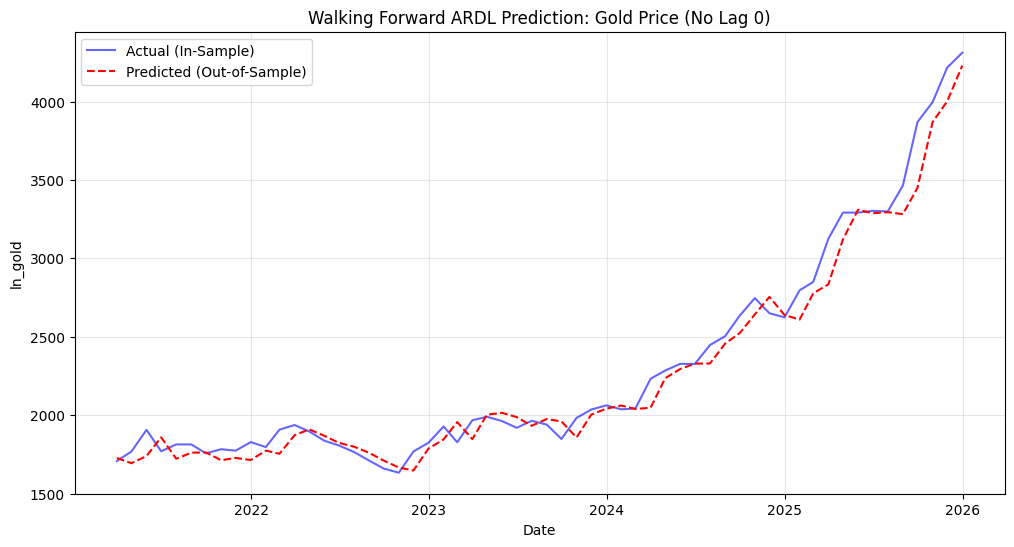

In [75]:
# Visualizing Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(np.exp(results['Actual']), label='Actual (In-Sample)', color='blue', alpha=0.6)
plt.plot(np.exp(results['Predicted']), label='Predicted (Out-of-Sample)', color='red', linestyle='--')
plt.title('Walking Forward ARDL Prediction: Gold Price (No Lag 0)')
plt.xlabel('Date')
plt.ylabel('ln_gold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [76]:
rmse = np.sqrt(mean_squared_error(np.exp(results['Actual']), np.exp(results['Predicted'])))
mae = mean_absolute_error(np.exp(results['Actual']), np.exp(results['Predicted']))
r2 = r2_score(np.exp(results['Actual']), np.exp(results['Predicted']))

print("-" * 50)
print(f"✅ Forecast Complete!")
print(f"Range: {results.index.min().date()} -> {results.index.max().date()}")
print(f"Total Forecasted Months: {len(results)}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE:  {mae:.5f}")
# print(f"R² (Out-of-Sample): {r2:.5f}") # อย่าตกใจถ้า R2 ติดลบ (เป็นปกติของ Time Series ระยะยาว)
print("-" * 50)

--------------------------------------------------
✅ Forecast Complete!
Range: 2021-03-31 -> 2025-12-31
Total Forecasted Months: 58
RMSE: 111.78678
MAE:  82.17926
--------------------------------------------------


## ACF

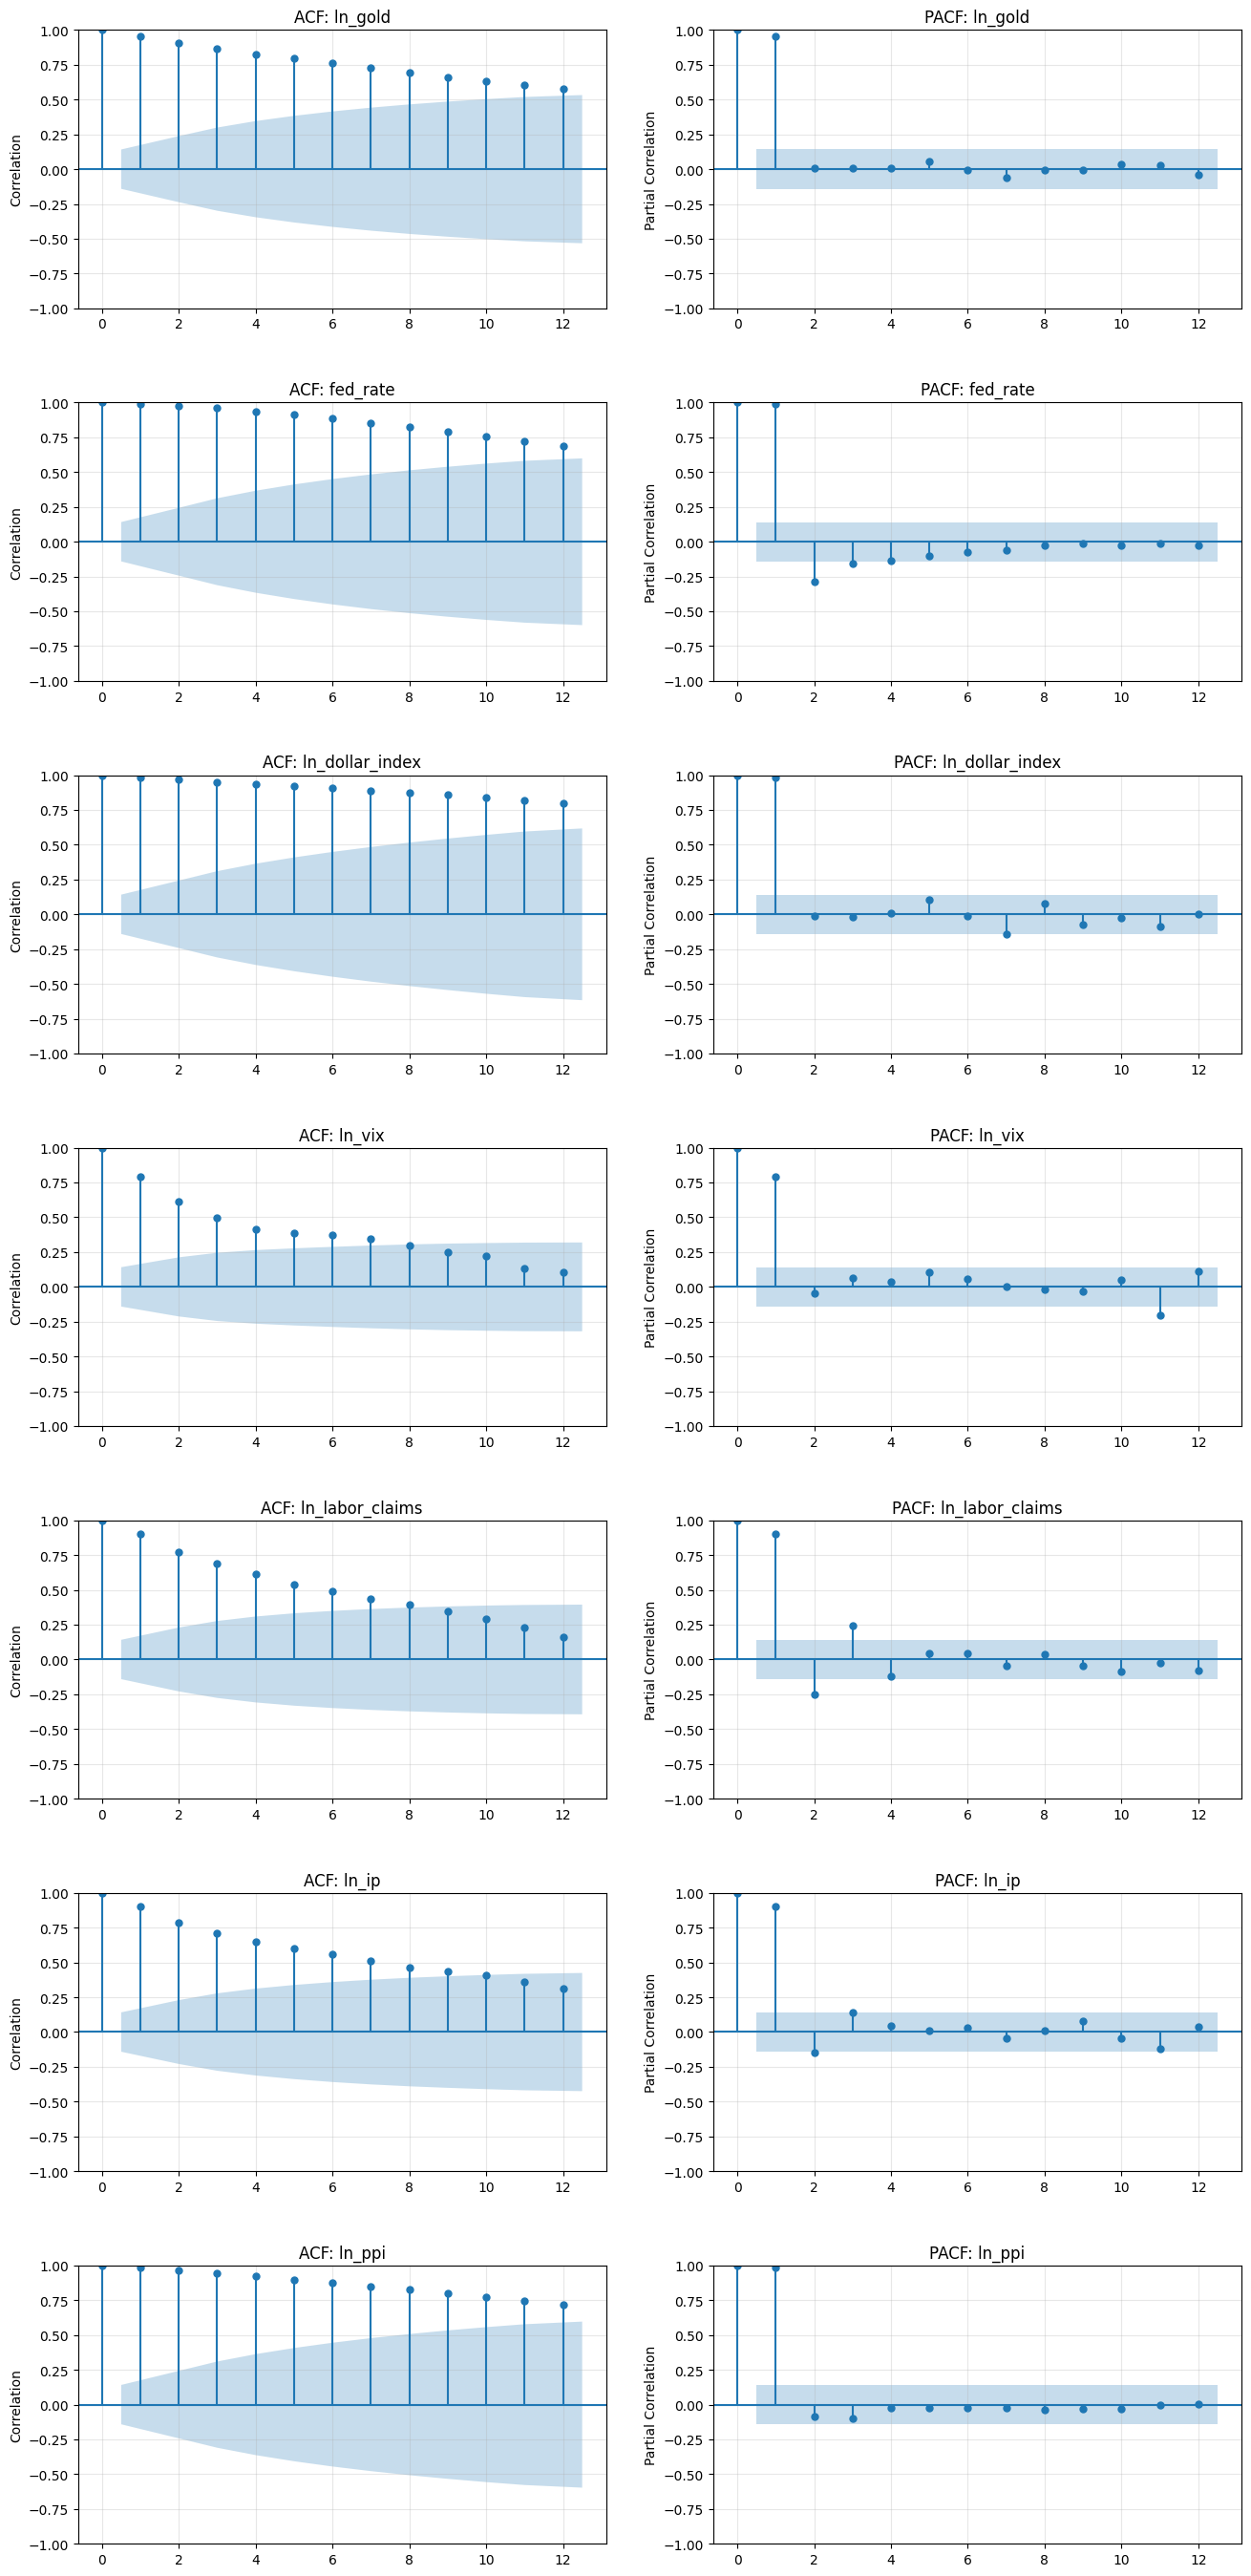

In [77]:
def plot_all_variables_lags(df, lags=12):
    num_cols = df.select_dtypes(include=['number']).columns
    n_vars = len(num_cols)
    
    fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(14, 4 * n_vars))
    
    plt.tight_layout(pad=5.0)
    
    for i, col in enumerate(num_cols):
        plot_acf(df[col].dropna(), lags=lags, ax=axes[i, 0], alpha=0.05)
        axes[i, 0].set_title(f"ACF: {col}")
        axes[i, 0].set_ylabel("Correlation")
        axes[i, 0].grid(True, alpha=0.3)

        plot_pacf(df[col].dropna(), lags=lags, ax=axes[i, 1], alpha=0.05, method='ywm')
        axes[i, 1].set_title(f"PACF: {col}")
        axes[i, 1].set_ylabel("Partial Correlation")
        axes[i, 1].grid(True, alpha=0.3)

    plt.show()
    
plot_all_variables_lags(data_ardl, lags=12)

## AIC ARDL WF Forecast

In [78]:
# 1. Extract and Transform Lags from AIC result (Excluding Lag 0)
best_order_no_lag0 = {}
for var, lags in sel_res.dl_lags.items():
    # Find the maximum lag selected by AIC
    max_l = max(lags) if isinstance(lags, (list, np.ndarray)) else lags
    
    if max_l >= 1:
        # Create a list of lags starting from 1 to max_l (e.g., [1, 2, 3])
        # This is required by statsmodels to avoid the "strictly positive" error
        best_order_no_lag0[var] = list(range(1, max_l + 1))
    else:
        # If AIC only chose Lag 0, force it to Lag 1 for forecasting capability
        best_order_no_lag0[var] = [1] 
        print(f"⚠️ Warning: {var} only had Lag 0. Forced to [1] for forecasting.")

X_cols = list(best_order_no_lag0.keys())


# --- Execution ---
# Clean data for ARDL execution
data_for_wf = df_ardl[[y_col] + X_cols].dropna()

# Run the simulation
results = run_walking_forward(data_for_wf, y_col, X_cols, best_order_no_lag0)

# --- Performance Evaluation ---
results['Error'] = results['Actual'] - results['Predicted']
results['Actual_Price'] = np.exp(results['Actual'])
results['Predicted_Price'] = np.exp(results['Predicted'])
results['Error_Price'] = results['Actual_Price'] - results['Predicted_Price']
print("\n--- Walking Forward Results ---")
results

Starting Walking Forward... Total Steps: 58
                               ARDL Model Results                              
Dep. Variable:                 ln_gold   No. Observations:                  191
Model:             ARDL(1, 1, 2, 1, 5)   Log Likelihood                 330.949
Method:                Conditional MLE   S.D. of innovations              0.042
Date:                 Mon, 02 Feb 2026   AIC                           -637.898
Time:                         17:07:21   BIC                           -598.934
Sample:                     06-30-2010   HQIC                          -622.114
                          - 11-30-2025                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1031      0.229     -0.450      0.654      -0.556       0.349
ln_gold.L1             0.9890      0.019     52.907    

,Actual,Predicted,Error,Actual_Price,Predicted_Price,Error_Price
Date,,,,,,
2021-03-31,7.442497,7.448021,-0.005524,1707.00745,1716.462451,-9.455001
2021-04-30,7.477938,7.433779,0.044159,1768.58997,1692.190483,76.399487
2021-05-31,7.552951,7.459641,0.093310,1906.35999,1736.524251,169.835739
2021-06-30,7.478623,7.524340,-0.045716,1769.80249,1852.589371,-82.786881
2021-07-31,7.503059,7.444202,0.058857,1813.58154,1709.919635,103.661905
2021-08-31,7.502974,7.467871,0.035104,1813.42810,1750.874494,62.553606
2021-09-30,7.471170,7.466534,0.004636,1756.66064,1748.536252,8.124388
2021-10-31,7.485945,7.439986,0.045959,1782.80823,1702.726702,80.081528
2021-11-30,7.480871,7.452332,0.028539,1773.78455,1723.877978,49.906572


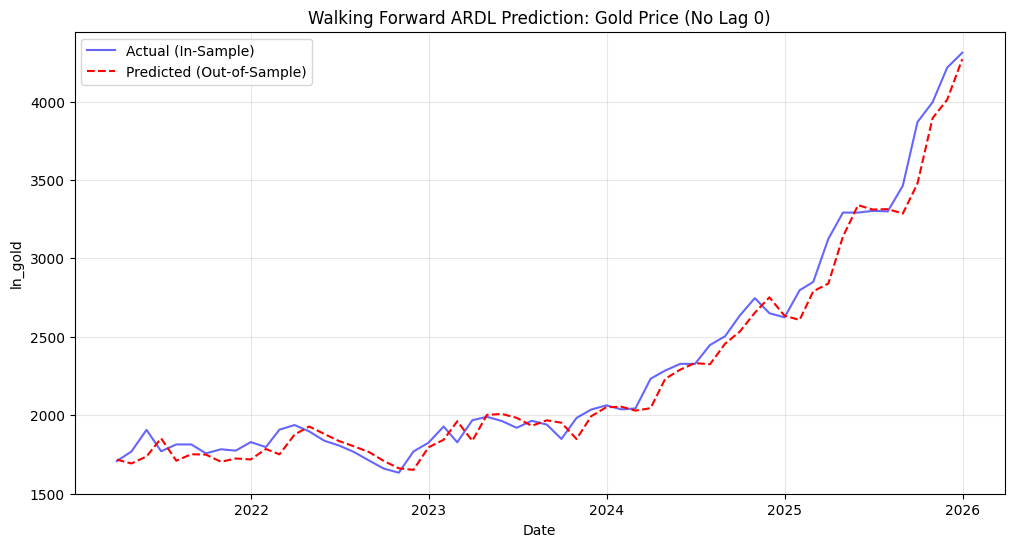

In [79]:
# Visualizing Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(np.exp(results['Actual']), label='Actual (In-Sample)', color='blue', alpha=0.6)
plt.plot(np.exp(results['Predicted']), label='Predicted (Out-of-Sample)', color='red', linestyle='--')
plt.title('Walking Forward ARDL Prediction: Gold Price (No Lag 0)')
plt.xlabel('Date')
plt.ylabel('ln_gold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [80]:
rmse = np.sqrt(mean_squared_error(np.exp(results['Actual']), np.exp(results['Predicted'])))
mae = mean_absolute_error(np.exp(results['Actual']), np.exp(results['Predicted']))
r2 = r2_score(np.exp(results['Actual']), np.exp(results['Predicted']))

print("-" * 50)
print(f"✅ Forecast Complete!")
print(f"Range: {results.index.min().date()} -> {results.index.max().date()}")
print(f"Total Forecasted Months: {len(results)}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE:  {mae:.5f}")
# print(f"R² (Out-of-Sample): {r2:.5f}") # อย่าตกใจถ้า R2 ติดลบ (เป็นปกติของ Time Series ระยะยาว)
print("-" * 50)

--------------------------------------------------
✅ Forecast Complete!
Range: 2021-03-31 -> 2025-12-31
Total Forecasted Months: 58
RMSE: 108.74974
MAE:  80.89166
--------------------------------------------------


## Technical Variables Integration ##

In [102]:
macro_feature = results[['Predicted']].copy()
macro_feature.columns = ['Macro_Signal']

macro_daily = macro_feature.resample('D').asfreq()
macro_daily = macro_daily.fillna(method='ffill')
macro_daily

/var/folders/rc/w7r40l35143bxwkzfxdygctc0000gn/T/ipykernel_15744/2938975789.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_daily = macro_daily.fillna(method='ffill')


,Macro_Signal
Date,
2021-03-31,7.448021
2021-04-01,7.448021
2021-04-02,7.448021
2021-04-03,7.448021
2021-04-04,7.448021
...,...
2025-12-27,8.296974
2025-12-28,8.296974
2025-12-29,8.296974


In [103]:
df_daily = pd.read_csv('all_gold_data.csv', index_col=0, parse_dates=True)
df_daily.sort_index(inplace=True)
df_daily = df_daily[~df_daily.index.duplicated(keep='first')]
df_daily['close_ret'] = np.log(df_daily['close']).diff()
df_daily['ln_close'] = np.log(df_daily['close'])

df_daily.ta.rsi(length=14, append=True) # Momentum
df_daily.ta.macd(fast=12, slow=26, signal=9, append=True) # Trend & Momentum
df_daily.ta.adx(length=14, append=True) # Trend Strength
df_daily.ta.cci(length=20, append=True) # Cyclical Trend
df_daily.ta.bbands(length=20, std=2, append=True) # Volatility
df_daily.ta.atr(length=14, append=True) # Volatility
df_daily.ta.ema(length=50, append=True)
df_daily.ta.ema(length=200, append=True)
df_daily['dist_ema50'] = (df_daily['close'] - df_daily['EMA_50']) / df_daily['EMA_50']
df_daily['dist_ema200'] = (df_daily['close'] - df_daily['EMA_200']) / df_daily['EMA_200']
df_daily['daily_range'] = (df_daily['high'] - df_daily['low']) / df_daily['open']

rolling_mean = df_daily['close'].rolling(window=20).mean()
rolling_std = df_daily['close'].rolling(window=20).std()
df_daily['z_score'] = (df_daily['close'] - rolling_mean) / rolling_std

cols_to_drop = [
    'EMA_50', 'EMA_200',      # เราใช้ dist_ema แทนแล้ว
    'BBU_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0' # เราใช้ bb_width กับ bb_percentage แทนแล้ว
]

cols_to_drop = [c for c in cols_to_drop if c in df_daily.columns]
df_daily.drop(columns=cols_to_drop, inplace=True)
df_daily.dropna(inplace=True)
df_daily

,open,high,low,close,close_ret,ln_close,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,...,DMP_14,DMN_14,CCI_20_0.015,BBB_20_2.0,BBP_20_2.0,ATRr_14,dist_ema50,dist_ema200,daily_range,z_score
datetime,,,,,,,,,,,,,,,,,,,,,
1988-10-10,409.67001,409.67001,408.07001,408.07001,1.309788e-02,6.011439,50.134210,-5.346590,1.844226,-7.190816,...,26.548163,32.599316,42.011343,8.409289,0.646692,3.810483,-0.019229,-0.077441,0.003906,0.571911
1988-10-11,410.17001,410.17001,404.03000,404.03000,-9.949620e-03,6.001489,44.573524,-4.806490,1.907461,-6.713951,...,23.620417,36.260496,29.467541,7.421808,0.559118,3.976878,-0.027836,-0.085787,0.014969,0.230486
1988-10-12,411.44000,411.44000,407.62000,407.62000,8.846235e-03,6.010335,49.892119,-4.042177,2.137419,-6.179596,...,22.807885,31.714852,74.803572,6.280292,0.738201,4.222101,-0.018459,-0.076951,0.009284,0.928678
1988-10-13,409.78000,409.78000,406.63000,406.63000,-2.431687e-03,6.007904,48.509718,-3.476267,2.162664,-5.638930,...,21.569976,31.699314,74.928054,5.354902,0.757891,4.145522,-0.020042,-0.078466,0.007687,1.005446
1988-10-14,410.78000,410.78000,408.79001,408.79001,5.297920e-03,6.013202,51.657035,-2.820965,2.254372,-5.075337,...,21.750615,29.432806,106.989009,5.116823,0.881994,4.145842,-0.014263,-0.072893,0.004844,1.489286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-29,5326.98804,5597.22988,5122.53750,5310.53137,-3.129935e-03,8.577447,89.536686,201.161081,51.416279,149.744802,...,58.690150,3.464801,170.118994,20.762581,1.006485,110.849386,0.151520,0.314961,0.089111,1.974641
2026-01-30,5308.49315,5451.71009,4706.06585,4940.66781,-7.219139e-02,8.505256,57.424586,181.606694,25.489514,156.117180,...,38.677232,21.329118,66.098246,20.010023,0.617938,156.191876,0.068332,0.220665,0.140463,0.459808
2026-01-31,4943.36462,4943.36462,4829.73898,4865.45982,-1.533928e-02,8.489917,53.243034,158.217215,1.680028,156.537187,...,36.627568,20.198801,13.503024,19.015377,0.522709,153.151430,0.049926,0.199671,0.022985,0.088535


In [104]:
df_final = macro_daily.join(df_daily, how='inner')
df_final['target_return'] = np.log(df_final['close']).diff().shift(-1)
df_final.dropna(inplace=True)

threshold = 0.00
conditions = [
    (df_final['target_return'] >= threshold),
    (df_final['target_return'] < -threshold)
]

choices = [1, 0]
df_final['signal'] = np.select(conditions, choices, default=0)

df_final.to_csv('gold_technical.csv')
df_final

,Macro_Signal,open,high,low,close,close_ret,ln_close,RSI_14,MACD_12_26_9,MACDh_12_26_9,...,CCI_20_0.015,BBB_20_2.0,BBP_20_2.0,ATRr_14,dist_ema50,dist_ema200,daily_range,z_score,target_return,signal
2021-03-31,7.448021,1685.59497,1715.27502,1677.92505,1707.00745,0.013097,7.442497,40.974529,-16.334942,0.342835,...,-98.216384,4.181243,0.305922,26.835012,-0.032888,-0.051302,0.022158,-0.756657,0.013485,1
2021-04-01,7.448021,1708.09009,1730.79822,1705.41956,1730.18201,0.013485,7.455982,48.013815,-14.335840,1.873550,...,2.230414,4.000791,0.609687,26.730987,-0.018998,-0.038055,0.014858,0.427638,-0.000776,0
2021-04-02,7.448021,1730.47498,1732.54504,1728.67249,1728.83997,-0.000776,7.455206,47.659348,-12.713277,2.796890,...,37.547100,3.834619,0.572885,25.098241,-0.018999,-0.038430,0.002238,0.284159,-0.000231,0
2021-04-05,7.448021,1728.74500,1733.75000,1721.21997,1728.43994,-0.000231,7.454975,47.546670,-11.329069,3.344878,...,17.839532,3.083127,0.538676,24.200512,-0.018486,-0.038282,0.007248,0.150786,0.008715,1
2021-04-06,7.448021,1728.49500,1745.67505,1726.82263,1743.56995,0.008715,7.463690,52.154204,-8.908517,4.612344,...,87.607246,3.138432,0.790971,23.818505,-0.009510,-0.029575,0.010907,1.134416,-0.003614,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-26,8.296974,4479.62443,4550.78973,4476.55334,4523.58231,0.009749,8.417060,83.036726,81.614524,15.478790,...,168.583951,9.003712,0.982387,50.861782,0.069260,0.195293,0.016572,1.880692,0.002011,1
2025-12-27,8.296974,4523.48301,4534.74851,4522.15204,4532.69019,0.002011,8.419071,83.528717,85.487616,15.481506,...,150.856861,9.300016,0.946295,48.128545,0.068420,0.195348,0.002785,1.739978,-0.000023,0
2025-12-28,8.296974,4532.61899,4532.88130,4531.44651,4532.58587,-0.000023,8.419048,83.498845,87.539551,14.026752,...,128.329053,9.244642,0.904088,44.793277,0.065538,0.193002,0.000317,1.575424,-0.044025,0
2025-12-29,8.296974,4532.61769,4547.90835,4307.57154,4337.36579,-0.044025,8.375022,48.525433,72.576478,-0.749056,...,18.659989,8.665716,0.399203,58.760672,0.018860,0.140013,0.053024,-0.392979,0.002153,1


## CNN

In [105]:
# Macro preparation
macro_for_cnn = pd.DataFrame(index=df_ret.index)
macro_for_cnn['macro_fed_change'] = df_ret['fed_change']

X_ols = sm.add_constant(df_ret[['fed_change']].shift(1))
macro_for_cnn['macro_resid'] = results['Error']

# Merge with daily technical data
df_cnn = df_final.copy()

features_to_merge = ['macro_fed_change', 'macro_resid']
for col in features_to_merge:
    daily_macro = macro_for_cnn[col].resample('D').ffill()
    df_cnn[col] = daily_macro
df_cnn.dropna(inplace=True)

# df_cnn
df_cnn.columns

Index(['Macro_Signal', 'open', 'high', 'low', 'close', 'close_ret', 'ln_close',
       'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14',
       'DMP_14', 'DMN_14', 'CCI_20_0.015', 'BBB_20_2.0', 'BBP_20_2.0',
       'ATRr_14', 'dist_ema50', 'dist_ema200', 'daily_range', 'z_score',
       'target_return', 'signal', 'macro_fed_change', 'macro_resid'],
      dtype='object')

In [106]:
df_cnn

,Macro_Signal,open,high,low,close,close_ret,ln_close,RSI_14,MACD_12_26_9,MACDh_12_26_9,...,BBP_20_2.0,ATRr_14,dist_ema50,dist_ema200,daily_range,z_score,target_return,signal,macro_fed_change,macro_resid
2021-03-31,7.448021,1685.59497,1715.27502,1677.92505,1707.00745,0.013097,7.442497,40.974529,-16.334942,0.342835,...,0.305922,26.835012,-0.032888,-0.051302,0.022158,-0.756657,0.013485,1,-0.0001,-0.005524
2021-04-01,7.448021,1708.09009,1730.79822,1705.41956,1730.18201,0.013485,7.455982,48.013815,-14.335840,1.873550,...,0.609687,26.730987,-0.018998,-0.038055,0.014858,0.427638,-0.000776,0,-0.0001,-0.005524
2021-04-02,7.448021,1730.47498,1732.54504,1728.67249,1728.83997,-0.000776,7.455206,47.659348,-12.713277,2.796890,...,0.572885,25.098241,-0.018999,-0.038430,0.002238,0.284159,-0.000231,0,-0.0001,-0.005524
2021-04-05,7.448021,1728.74500,1733.75000,1721.21997,1728.43994,-0.000231,7.454975,47.546670,-11.329069,3.344878,...,0.538676,24.200512,-0.018486,-0.038282,0.007248,0.150786,0.008715,1,-0.0001,-0.005524
2021-04-06,7.448021,1728.49500,1745.67505,1726.82263,1743.56995,0.008715,7.463690,52.154204,-8.908517,4.612344,...,0.790971,23.818505,-0.009510,-0.029575,0.010907,1.134416,-0.003614,0,-0.0001,-0.005524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-26,8.296974,4479.62443,4550.78973,4476.55334,4523.58231,0.009749,8.417060,83.036726,81.614524,15.478790,...,0.982387,50.861782,0.069260,0.195293,0.016572,1.880692,0.002011,1,-0.0021,0.049749
2025-12-27,8.296974,4523.48301,4534.74851,4522.15204,4532.69019,0.002011,8.419071,83.528717,85.487616,15.481506,...,0.946295,48.128545,0.068420,0.195348,0.002785,1.739978,-0.000023,0,-0.0021,0.049749
2025-12-28,8.296974,4532.61899,4532.88130,4531.44651,4532.58587,-0.000023,8.419048,83.498845,87.539551,14.026752,...,0.904088,44.793277,0.065538,0.193002,0.000317,1.575424,-0.044025,0,-0.0021,0.049749
2025-12-29,8.296974,4532.61769,4547.90835,4307.57154,4337.36579,-0.044025,8.375022,48.525433,72.576478,-0.749056,...,0.399203,58.760672,0.018860,0.140013,0.053024,-0.392979,0.002153,1,-0.0021,0.049749


In [107]:
cnn_features = [
    'ln_close', 'RSI_14', 'MACD_12_26_9', 'MACDs_12_26_9', 'ADX_14', 
    'CCI_20_0.015', 'ATRr_14', 'daily_range', 'z_score', 'dist_ema50',
    'Macro_Signal', 'macro_fed_change', 'macro_resid'
]

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_raw = df_cnn[cnn_features].values
y_raw = df_cnn[['target_return']].values # ทำนาย Return

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

def create_sequences(data_X, data_y, time_steps):
    Xs, ys = [], []
    for i in range(len(data_X) - time_steps):
        Xs.append(data_X[i:(i + time_steps)])
        ys.append(data_y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 9
X_cnn, y_cnn = create_sequences(X_scaled, y_scaled, TIME_STEPS)

# Train/Test (no Shuffle : Time Series)
train_size = int(len(X_cnn) * 0.95)
X_train, X_test = X_cnn[:train_size], X_cnn[train_size:]
y_train, y_test = y_cnn[:train_size], y_cnn[train_size:]

print(f"Input Shape: {X_train.shape} (Samples, Time Steps, Features)")

Input Shape: (1241, 9, 13) (Samples, Time Steps, Features)


In [108]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    
    # --- Block 1: Short-term Patterns ---
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    # --- Block 2: Long-term Trends ---
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    # --- Interpretation ---
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.1), # Prevent overfitting
    
    # --- Output ---
    Dense(32, activation='relu'),
    Dense(1, activation='linear') # Linear activation for regression
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 9, 32)          │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 9, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 192 (768.00 B)

In [109]:
# Stop training if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.2563 - mae: 0.8488 - val_loss: 0.3373 - val_mae: 0.5711 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1770 - mae: 0.3326 - val_loss: 0.3268 - val_mae: 0.5619 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0850 - mae: 0.2326 - val_loss: 0.2778 - val_mae: 0.5162 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0641 - mae: 0.2023 - val_loss: 0.2711 - val_mae: 0.5096 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0513 - mae: 0.1808 - val_loss: 0.2838 - val_mae: 0.5219 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0449 - mae: 0.1660 - val_loss: 0.2676 - val_mae: 0.5061 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0379 - mae: 0.1539 - val_loss: 0.2743 - val_mae: 0.5128 - learning_rate: 0.0010
Epoch 8/50
10/10 ━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


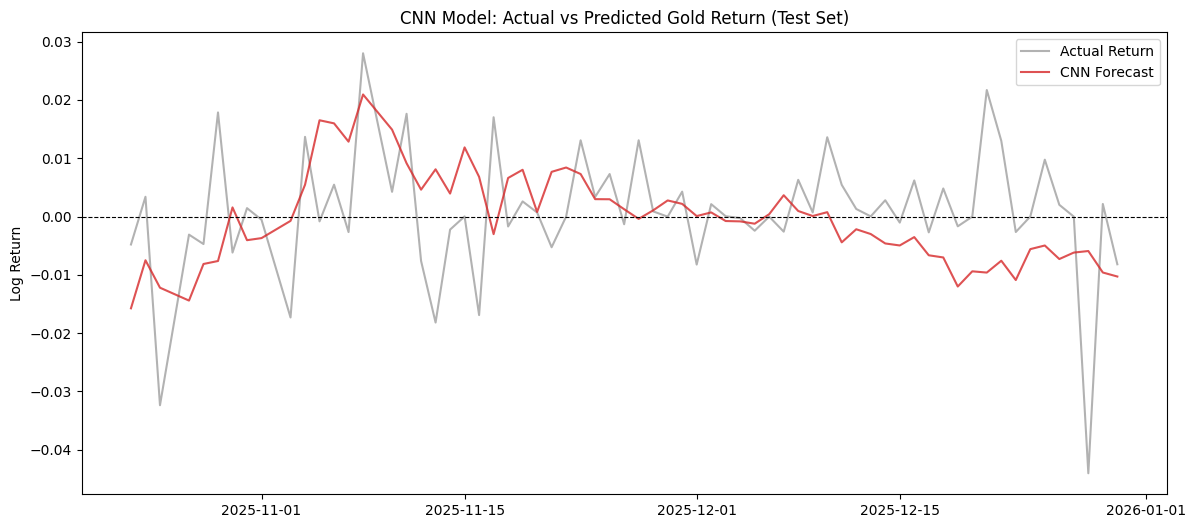

In [110]:
# Prediction
y_pred_scaled = model.predict(X_test)

# Inverse Transform (Back to real return values)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

test_start_idx = train_size + TIME_STEPS
dates = df_cnn.index[test_start_idx : test_start_idx + len(y_actual)]

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual Return', color='gray', alpha=0.6)
plt.plot(dates, y_pred, label='CNN Forecast', color='#D62728', alpha=0.8, linewidth=1.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Zero line
plt.title('CNN Model: Actual vs Predicted Gold Return (Test Set)')
plt.ylabel('Log Return')
plt.legend()

## CNN-LSTM

In [111]:
# --- 1. Model Architecture (Based on Livieris et al., 2020) ---
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), # ( Time Steps, n_features)
    
    # --- Part 1: CNN Layers (Feature Extraction) ---
    # Layer 1: สกัด Feature พื้นฐาน (32-64 Filters ในเปเปอร์ แต่เราอัดไป 64 เพื่อเก็บรายละเอียด Technical)
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    
    # Layer 2: สกัด Feature ที่ซับซ้อนขึ้น (128 Filters ตามเปเปอร์)
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    
    # Pooling: ย่อข้อมูลลงครึ่งหนึ่ง (เพื่อคัดเนื้อๆ เน้นๆ)
    MaxPooling1D(pool_size=2),
    
    # --- Part 2: LSTM Layer (Temporal Learning) ---
    # รับไม้ต่อจาก CNN เพื่อดู "ลำดับเวลา" ของ Feature ที่สกัดมาได้
    # (ในเปเปอร์ใช้ 200 units ซึ่งถือว่าใหญ่และดีสำหรับข้อมูลที่มีความซับซ้อน)
    LSTM(200, return_sequences=False, activation='tanh'),
    Dropout(0.1), # ป้องกันการจำข้อสอบ (Overfitting)
    
    # --- Part 3: Fully Connected (Interpretation) ---
    Dense(32, activation='relu'), # Hidden Layer ตามเปเปอร์
    
    # Output Layer (ทำนาย Return)
    Dense(1, activation='linear')
])

# --- 2. Optimizer & Compilation ---
# ใช้ Adam (มาตรฐานโลก) และ Loss เป็น MSE
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

# # --- 3. Training ---
# # ใช้ Callbacks เดิม (EarlyStopping, ReduceLR) เพราะดีอยู่แล้ว
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 9, 64)          │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 9, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200)            │       263,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,697 (1.14 MB)

 Trainable params: 297,313 (1.13 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.4721 - mae: 0.5646 - val_loss: 0.2877 - val_mae: 0.5234 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0293 - mae: 0.1349 - val_loss: 0.2716 - val_mae: 0.5063 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0140 - mae: 0.0905 - val_loss: 0.2731 - val_mae: 0.5077 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127 - mae: 0.0866 - val_loss: 0.2800 - val_mae: 0.5138 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0121 - mae: 0.0863 - val_loss: 0.3003 - val_mae: 0.5327 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0108 - mae: 0.0793 - val_loss: 0.3360 - val_mae: 0.5639 - learning_rate: 0.0010
Epoch 7/50
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0807 
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


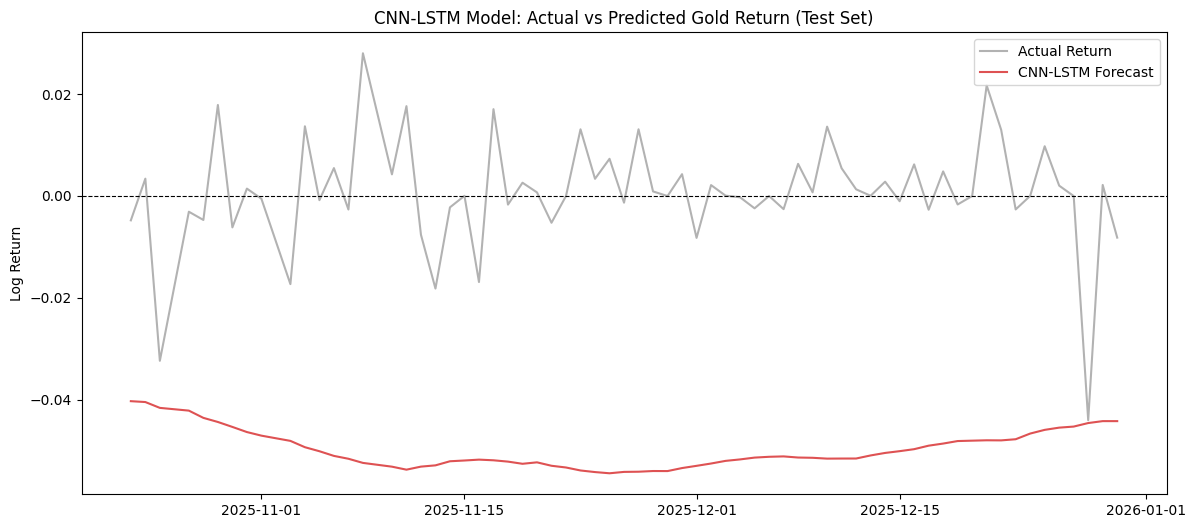

In [112]:
# Prediction
y_pred_scaled = model.predict(X_test)

# Inverse Transform (Back to real return values)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

test_start_idx = train_size + TIME_STEPS
dates = df_cnn.index[test_start_idx : test_start_idx + len(y_actual)]

# Visualization
plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual Return', color='gray', alpha=0.6)
plt.plot(dates, y_pred, label='CNN-LSTM Forecast', color='#D62728', alpha=0.8, linewidth=1.5)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Zero line
plt.title('CNN-LSTM Model: Actual vs Predicted Gold Return (Test Set)')
plt.ylabel('Log Return')
plt.legend()